# TensorDiffEq for Helmholtz

## pip install tensordiffeq

In [ ]:
!pip install tensordiffeq

## install tex fonts for the plotting routine (if needed, may be skipped)

In [ ]:
!apt-get install texlive-latex-recommended 
!apt install texlive-latex-extra texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


## Helmholtz from `https://github.com/tensordiffeq/TensorDiffEq/blob/main/examples/steady-state.py`

In [ ]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensordiffeq as tdq
from tensordiffeq.boundaries import *
from tensordiffeq.models import CollocationSolverND
from tensorflow.math import sin
from tensordiffeq.utils import constant

from tensordiffeq.plotting import *

Domain = DomainND(["x", "y"])

Domain.add("x", [-1.0, 1.0], 1001)
Domain.add("y", [-1.0, 1.0], 1001)

N_f = 10000
Domain.generate_collocation_points(N_f)


def f_model(u_model, x, y):
    u = u_model(tf.concat([x, y], 1))
    u_x = tf.gradients(u, x)[0]
    u_y = tf.gradients(u, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    a1 = constant(1.0)
    a2 = constant(4.0)
    ksq = constant(1.0)
    pi = constant(math.pi)

    # we use this specific forcing term because we have an exact analytical solution for this case
    # to compare the results of the PINN solution
    # note that we must use tensorflow math primitives such as sin, cos, etc!
    forcing = - (a1 * pi) ** 2 * sin(a1 * pi * x) * sin(a2 * pi * y) - \
              (a2 * pi) ** 2 * sin(a1 * pi * x) * sin(a2 * pi * y) + \
              ksq * sin(a1 * pi * x) * sin(a2 * pi * y)

    f_u = u_xx + u_yy + ksq * u - forcing  # = 0

    return f_u


upper_x = dirichletBC(Domain, val=0.0, var='x', target="upper")
lower_x = dirichletBC(Domain, val=0.0, var='x', target="lower")
upper_y = dirichletBC(Domain, val=0.0, var='y', target="upper")
lower_y = dirichletBC(Domain, val=0.0, var='y', target="lower")

BCs = [upper_x, lower_x, upper_y, lower_y]

layer_sizes = [2, 50, 50, 50, 50, 1]

model = CollocationSolverND()
model.compile(layer_sizes, f_model, Domain, BCs)

# TDQ example has 10k,10k - here 3k per adam/adam works. With SA-PINN more iterations are required.
# More iterations here will yield more accuracy, of course.
model.fit(tf_iter=3000, newton_iter=3000)



starting Adam training
It: 0, Time: 2.00
total loss: 6971.8544921875
It: 100, Time: 0.93
total loss: 4166.189453125
It: 200, Time: 0.87
total loss: 2241.856689453125
It: 300, Time: 0.87
total loss: 1648.008056640625
It: 400, Time: 0.87
total loss: 1023.6297607421875
It: 500, Time: 0.87
total loss: 622.2557983398438
It: 600, Time: 0.88
total loss: 185.74948120117188
It: 700, Time: 0.87
total loss: 113.8072509765625
It: 800, Time: 0.88
total loss: 77.90478515625
It: 900, Time: 0.88
total loss: 55.64616394042969
It: 1000, Time: 0.88
total loss: 35.82587432861328
It: 1100, Time: 0.88
total loss: 15.606059074401855
It: 1200, Time: 0.88
total loss: 9.783634185791016
It: 1300, Time: 0.88
total loss: 6.426933288574219
It: 1400, Time: 0.88
total loss: 4.694986820220947
It: 1500, Time: 0.88
total loss: 3.5496509075164795
It: 1600, Time: 0.89
total loss: 2.7730846405029297
It: 1700, Time: 0.89
total loss: 2.512239933013916
It: 1800, Time: 0.89
total loss: 1.9885332584381104
It: 1900, Time: 0.89
t

## Plotting

In [ ]:
# get exact solution
nx, ny = (1001, 1001)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)

xv, yv = np.meshgrid(x, y)

x = np.reshape(x, (-1, 1))
y = np.reshape(y, (-1, 1))

# Exact analytical soln is available:
Exact_u = np.sin(math.pi * xv) * np.sin(4 * math.pi * yv)

# Flatten for use
u_star = Exact_u.flatten()[:, None]

# Plotting
x = Domain.domaindict[0]['xlinspace']
y = Domain.domaindict[1]["ylinspace"]

X, Y = np.meshgrid(x, y)

# print(np.shape((X,Y))) # 2, 256, 256
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

lb = np.array([-1.0, -1.0])
ub = np.array([1.0, 1])

u_pred, f_u_pred = model.predict(X_star)

error_u = tdq.helpers.find_L2_error(u_pred, u_star)
print('Error u: %e' % (error_u))


Error u: 3.089495e-02


The above error is the L2 error across the entire domain for all 1m points in the domain. So the actual error per timestep is relatively small. There are 1000 timesteps, so we can appriximate an error of the above number % 1000 for the avg residual at each timestep. 

Manual plotting for a bug where the transpose of the solution is displayed. Will be repaired in a later release. 

No handles with labels found to put in legend.


Text(0.5, 1.0, '$x = 0.50$')

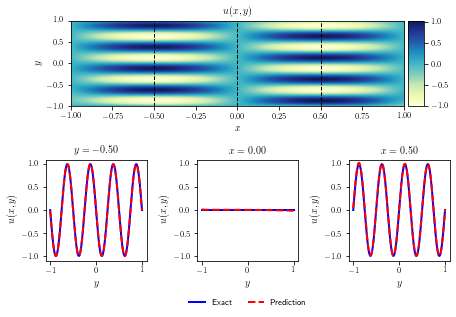

In [ ]:
U_pred = tdq.plotting.get_griddata(X_star, u_pred.T.flatten(), (X, Y))
FU_pred = tdq.plotting.get_griddata(X_star, f_u_pred.T.flatten(), (X, Y))

fig, ax = newfig(1.3, 1.0)
ax.axis('off')

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred, interpolation='nearest', cmap='YlGnBu',
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[250]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(y[500]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(y[750]*np.ones((2,1)), line, 'k--', linewidth = 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
leg = ax.legend(frameon=False, loc = 'best')

ax.set_title('$u(x,y)$', fontsize = 10)

####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_u[:,250], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,250], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.set_title('$y = %.2f$' % (y[250]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_u[:,500], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,500], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$x = %.2f$' % (y[500]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_u[:,750], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,750], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$x = %.2f$' % (y[750]), fontsize = 10)